In [1]:
pwd

'e:\\two_stage_model\\data_processing\\geo_processing'

In [2]:
cd ..

e:\two_stage_model\data_processing


In [3]:
%load_ext line_profiler

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
import contextily as ctx

In [5]:
country_name = 'Cranberry'
model_path = 'E:/two_stage_model'

## Part 1. Read Files

In [6]:
# TMC Speed Data
df_spd = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "rb"))
speed_available_tmc_list = list(df_spd.columns)

In [7]:
speed_available_tmc_list = list(df_spd.columns)

In [8]:
# Shape
gdf_tmc_raw = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_tmc_raw = gdf_tmc_raw.rename(columns={"tmc":"id_tmc"})

In [9]:
# neighbour info
dict_prev_tmc = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_dict_prev_tmc.pkl", "rb"))

In [10]:
gdf_tmc_raw # for TMSO network, 1591 links totally

,fid,id_tmc,miles,direction,type_x,type_y,road_order,roadname,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude,geometry
0,1,104-08640,0.472527,SOUTHBOUND,P3.2,Feature,1.0,W CARSON ST,PA-837,ALLEGHENY,PA,15219,40.44278,-80.02468,40.43960,-80.01675,"MULTILINESTRING ((-80.02468 40.44278, -80.0244..."
1,2,104P50769,0.018409,WESTBOUND,P1.11,Feature,1.0,RIDGE AVE,NaN,ALLEGHENY,PA,15233,40.44938,-80.02277,40.44950,-80.02308,"MULTILINESTRING ((-80.02277 40.44938, -80.0228..."
2,3,104-04517,0.028464,WESTBOUND,P1.3,Feature,1.0,I-376 W,I-376,ALLEGHENY,PA,15219,40.43832,-80.01230,40.43808,-80.01274,"MULTILINESTRING ((-80.01230 40.43832, -80.0125..."
3,4,104-04551,0.143105,SOUTHBOUND,P1.3,Feature,1.0,NaN,I-579,ALLEGHENY,PA,15212,40.45402,-79.99763,40.45224,-79.99626,"MULTILINESTRING ((-79.99763 40.45402, -79.9975..."
4,5,104-04555,0.127161,SOUTHBOUND,P1.3,Feature,1.0,I-579,I-579,ALLEGHENY,PA,15212,40.45407,-79.99725,40.45242,-79.99620,"MULTILINESTRING ((-79.99725 40.45407, -79.9970..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1148,104+06678,0.245088,NORTHBOUND,P1.11,Feature,724.0,US-19,US-19,BUTLER,PA,16066,40.68140,-80.10045,40.68489,-80.10129,"MULTILINESTRING ((-80.10045 40.68140, -80.1005..."
1148,1149,104+06679,0.999430,NORTHBOUND,P1.11,Feature,726.0,US-19,US-19,BUTLER,PA,16066,40.68489,-80.10129,40.69906,-80.10449,"MULTILINESTRING ((-80.10129 40.68489, -80.1014..."
1149,1150,104+06680,1.637619,NORTHBOUND,P1.11,Feature,727.0,US-19,US-19,BUTLER,PA,16066,40.69906,-80.10449,40.72256,-80.10622,"MULTILINESTRING ((-80.10449 40.69906, -80.1044..."
1150,1151,104+06681,2.383581,NORTHBOUND,P1.11,Feature,728.0,US-19,US-19,BUTLER,PA,16066,40.72256,-80.10622,40.75597,-80.11749,"MULTILINESTRING ((-80.10622 40.72256, -80.1062..."


## Part 2. Generate Upstream Dict (Currently, it's for selected TMC Link Only)

In [11]:
# build link-length dictionary
Link_Length_Dict = {}

for tmc_id in list(gdf_tmc_raw['id_tmc']):
    Link_Length_Dict[tmc_id] = None
    
for tmc_id in list(gdf_tmc_raw['id_tmc']):
    Link_Length_Dict[tmc_id] = float(pd.to_numeric(gdf_tmc_raw[gdf_tmc_raw['id_tmc']==tmc_id]['miles']))

C:\Users\haowu\AppData\Local\Temp\ipykernel_859036\584354739.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Link_Length_Dict[tmc_id] = float(pd.to_numeric(gdf_tmc_raw[gdf_tmc_raw['id_tmc']==tmc_id]['miles']))
C:\Users\haowu\AppData\Local\Temp\ipykernel_859036\584354739.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Link_Length_Dict[tmc_id] = float(pd.to_numeric(gdf_tmc_raw[gdf_tmc_raw['id_tmc']==tmc_id]['miles']))
C:\Users\haowu\AppData\Local\Temp\ipykernel_859036\584354739.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Link_Length_Dict[tmc_id] = float(pd.to_numeric(gdf_tmc_raw[gdf_tmc_raw['id_tmc']==tmc_id]['miles']))
C:\Users\haowu\AppData\Local\Temp\ipykernel_859036\584354739.

In [12]:
# build upstream link dict
upstream_link_dict = {}
for keys in tqdm(dict_prev_tmc.keys()):
    upstream_link_dict[keys] = []
    
for keys in tqdm(dict_prev_tmc.keys()):
    new_link_list = []
    for link in dict_prev_tmc[keys]:
        new_link_list.append(link)
        upstream_link_dict[keys] = new_link_list

100%|██████████| 2406/2406 [00:00<00:00, 2397599.29it/s]


### For Cranberry Map, the link in dict_prev_tmc is from 3 countries, we only keep those in the selected area. 

In [13]:
def filter_dict_by_list(the_list, the_dict):
    keys_to_remove = [key for key in the_dict if key not in the_list]
    for key in keys_to_remove:
        del the_dict[key]
    for key in the_dict:
        the_dict[key] = [item for item in the_dict[key] if item in the_list]

    return the_dict

In [14]:
len(upstream_link_dict.keys())

2406

In [15]:
upstream_link_dict = filter_dict_by_list(list(gdf_tmc_raw['id_tmc']), upstream_link_dict)

In [16]:
len(upstream_link_dict.keys())

1080

In [17]:
def compute_length(link_list:list):
    length = 0
    for link in link_list:
        length += Link_Length_Dict[link]
    return length

In [26]:
# check speed_available_tmc_list
# check selected_tmc_list
def build_up_k_mile_upstream_dict(k_mile):
    element_count = 0 # count the number of route found in the whole network (for selected tmc segements only)
    upstream_k_mile_dict = {} # the final return value 
    for tmc_id in tqdm(upstream_link_dict.keys()): # intinal keys in the dict, we only need to know selected links info
        upstream_k_mile_dict[tmc_id] = []

    # for each selected tmc link, we have a route list, for each route, the first is the total length, the else is the link id
    # initialize the tmc link dict

    for tmc_id in tqdm(upstream_k_mile_dict.keys()):
        new_route_list = []
        for upstream_id in upstream_link_dict[tmc_id]:
            new_link_list = [compute_length([upstream_id]), upstream_id]
            new_route_list.append(new_link_list)
        element_count += len(new_route_list)
        upstream_k_mile_dict[tmc_id] = new_route_list
    
    new_element_count = 0
    while new_element_count != element_count:
        element_count = new_element_count
        new_element_count= 0
        for tmc_id in tqdm(upstream_k_mile_dict.keys()):
            new_route_list = []
            old_route_list = upstream_k_mile_dict[tmc_id]
            for route in old_route_list:
                if route[0] >= k_mile:
                    new_route_list.append(route)
                else:
                    latest_upstream_link = route[-1]
                    if latest_upstream_link in upstream_link_dict.keys():
                        for new_upstream_link in upstream_link_dict[latest_upstream_link]:
                            new_route = deepcopy(route[1:])
                            new_route.append(new_upstream_link)
                            new_route.insert(0, compute_length(new_route))
                            new_route_list.append(new_route)
                    else:
                        new_route_list.append(route)
            new_element_count += len(new_route_list)
            upstream_k_mile_dict[tmc_id] = new_route_list
    
    # delete the length indicator
    for tmc_id in upstream_k_mile_dict.keys():
        if len(upstream_k_mile_dict[tmc_id])!=0:
            for link_list in upstream_k_mile_dict[tmc_id]:
                del link_list[0]
    
    key_list = deepcopy(list(upstream_k_mile_dict.keys()))
    for tmc_id in tqdm(key_list):
        if tmc_id not in speed_available_tmc_list: # for this dict key, we do not contain the link that speed info is not available
            del upstream_k_mile_dict[tmc_id]
        else:
            upstream_route_list = deepcopy(upstream_k_mile_dict[tmc_id])
            link_list = []
            for route in upstream_route_list:
                for link in route:
                    if link in speed_available_tmc_list: # for the dict value, we only consider the link that speed info is not available
                        link_list.append(link)
            link_list = list(set(link_list))
            upstream_k_mile_dict[tmc_id] = link_list
    
    return upstream_k_mile_dict

## Part 3. Generate Downstream Dict

In [19]:
def reverse_dict(d):
    new_dict = {}
    for key, values in d.items():
        for value in values:
            if value not in new_dict:
                new_dict[value] = [key]
            else:
                new_dict[value].append(key)
    for key in new_dict.keys():
        new_dict[key] = list(set(new_dict[key]))
    return new_dict

In [20]:
downstream_link_dict = reverse_dict(upstream_link_dict)

In [21]:
# save for adjcency matrix generation
pickle.dump(downstream_link_dict, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_downstream_dict.pkl", "wb"))

In [22]:
def build_up_k_mile_downstream_dict(k_mile):
    element_count = 0 # count the number of route found in the whole network (for selected tmc segements only)
    downstream_k_mile_dict = {} # the final return value 
    for tmc_id in tqdm(downstream_link_dict.keys()): # intinal keys in the dict, we only need to know selected links info
        downstream_k_mile_dict[tmc_id] = []

    # for each selected tmc link, we have a route list, for each route, the first is the total length, the else is the link id
    # initialize the tmc link dict

    for tmc_id in tqdm(downstream_k_mile_dict.keys()):
        new_route_list = []
        for downstream_id in downstream_link_dict[tmc_id]:
            new_link_list = [compute_length([downstream_id]), downstream_id]
            new_route_list.append(new_link_list)
        element_count += len(new_route_list)
        downstream_k_mile_dict[tmc_id] = new_route_list
    
    new_element_count = 0
    while new_element_count != element_count:
        element_count = new_element_count
        new_element_count= 0
        for tmc_id in tqdm(downstream_k_mile_dict.keys()):
            new_route_list = []
            old_route_list = downstream_k_mile_dict[tmc_id]
            for route in old_route_list:
                if route[0] >= k_mile:
                    new_route_list.append(route)
                else:
                    latest_downstream_link = route[-1]
                    if latest_downstream_link in downstream_link_dict.keys():
                        for new_downstream_link in downstream_link_dict[latest_downstream_link]:
                            new_route = deepcopy(route[1:])
                            new_route.append(new_downstream_link)
                            new_route.insert(0, compute_length(new_route))
                            new_route_list.append(new_route)
                    else:
                        new_route_list.append(route)
            new_element_count += len(new_route_list)
            downstream_k_mile_dict[tmc_id] = new_route_list
    
    # delete the length indicator
    for tmc_id in downstream_k_mile_dict.keys():
        if len(downstream_k_mile_dict[tmc_id])!=0:
            for link_list in downstream_k_mile_dict[tmc_id]:
                del link_list[0]
    
    key_list = deepcopy(list(downstream_k_mile_dict.keys()))
    for tmc_id in tqdm(key_list):
        if tmc_id not in speed_available_tmc_list: # for this dict key, we do not contain the link that speed info is not available
            del downstream_k_mile_dict[tmc_id]
        else:
            downstream_route_list = deepcopy(downstream_k_mile_dict[tmc_id])
            link_list = []
            for route in downstream_route_list:
                for link in route:
                    if link in speed_available_tmc_list: # for the dict value, we only consider the link that speed info is not available
                        link_list.append(link)
            link_list = list(set(link_list))
            downstream_k_mile_dict[tmc_id] = link_list
    
    return downstream_k_mile_dict

In [23]:
len(list(upstream_link_dict.keys()))

1080

In [29]:
upstream_k_mile_dict = build_up_k_mile_upstream_dict(2)
downstream_k_mile_dict = build_up_k_mile_downstream_dict(1)

100%|██████████| 1047/1047 [00:00<00:00, 8519.85it/s]


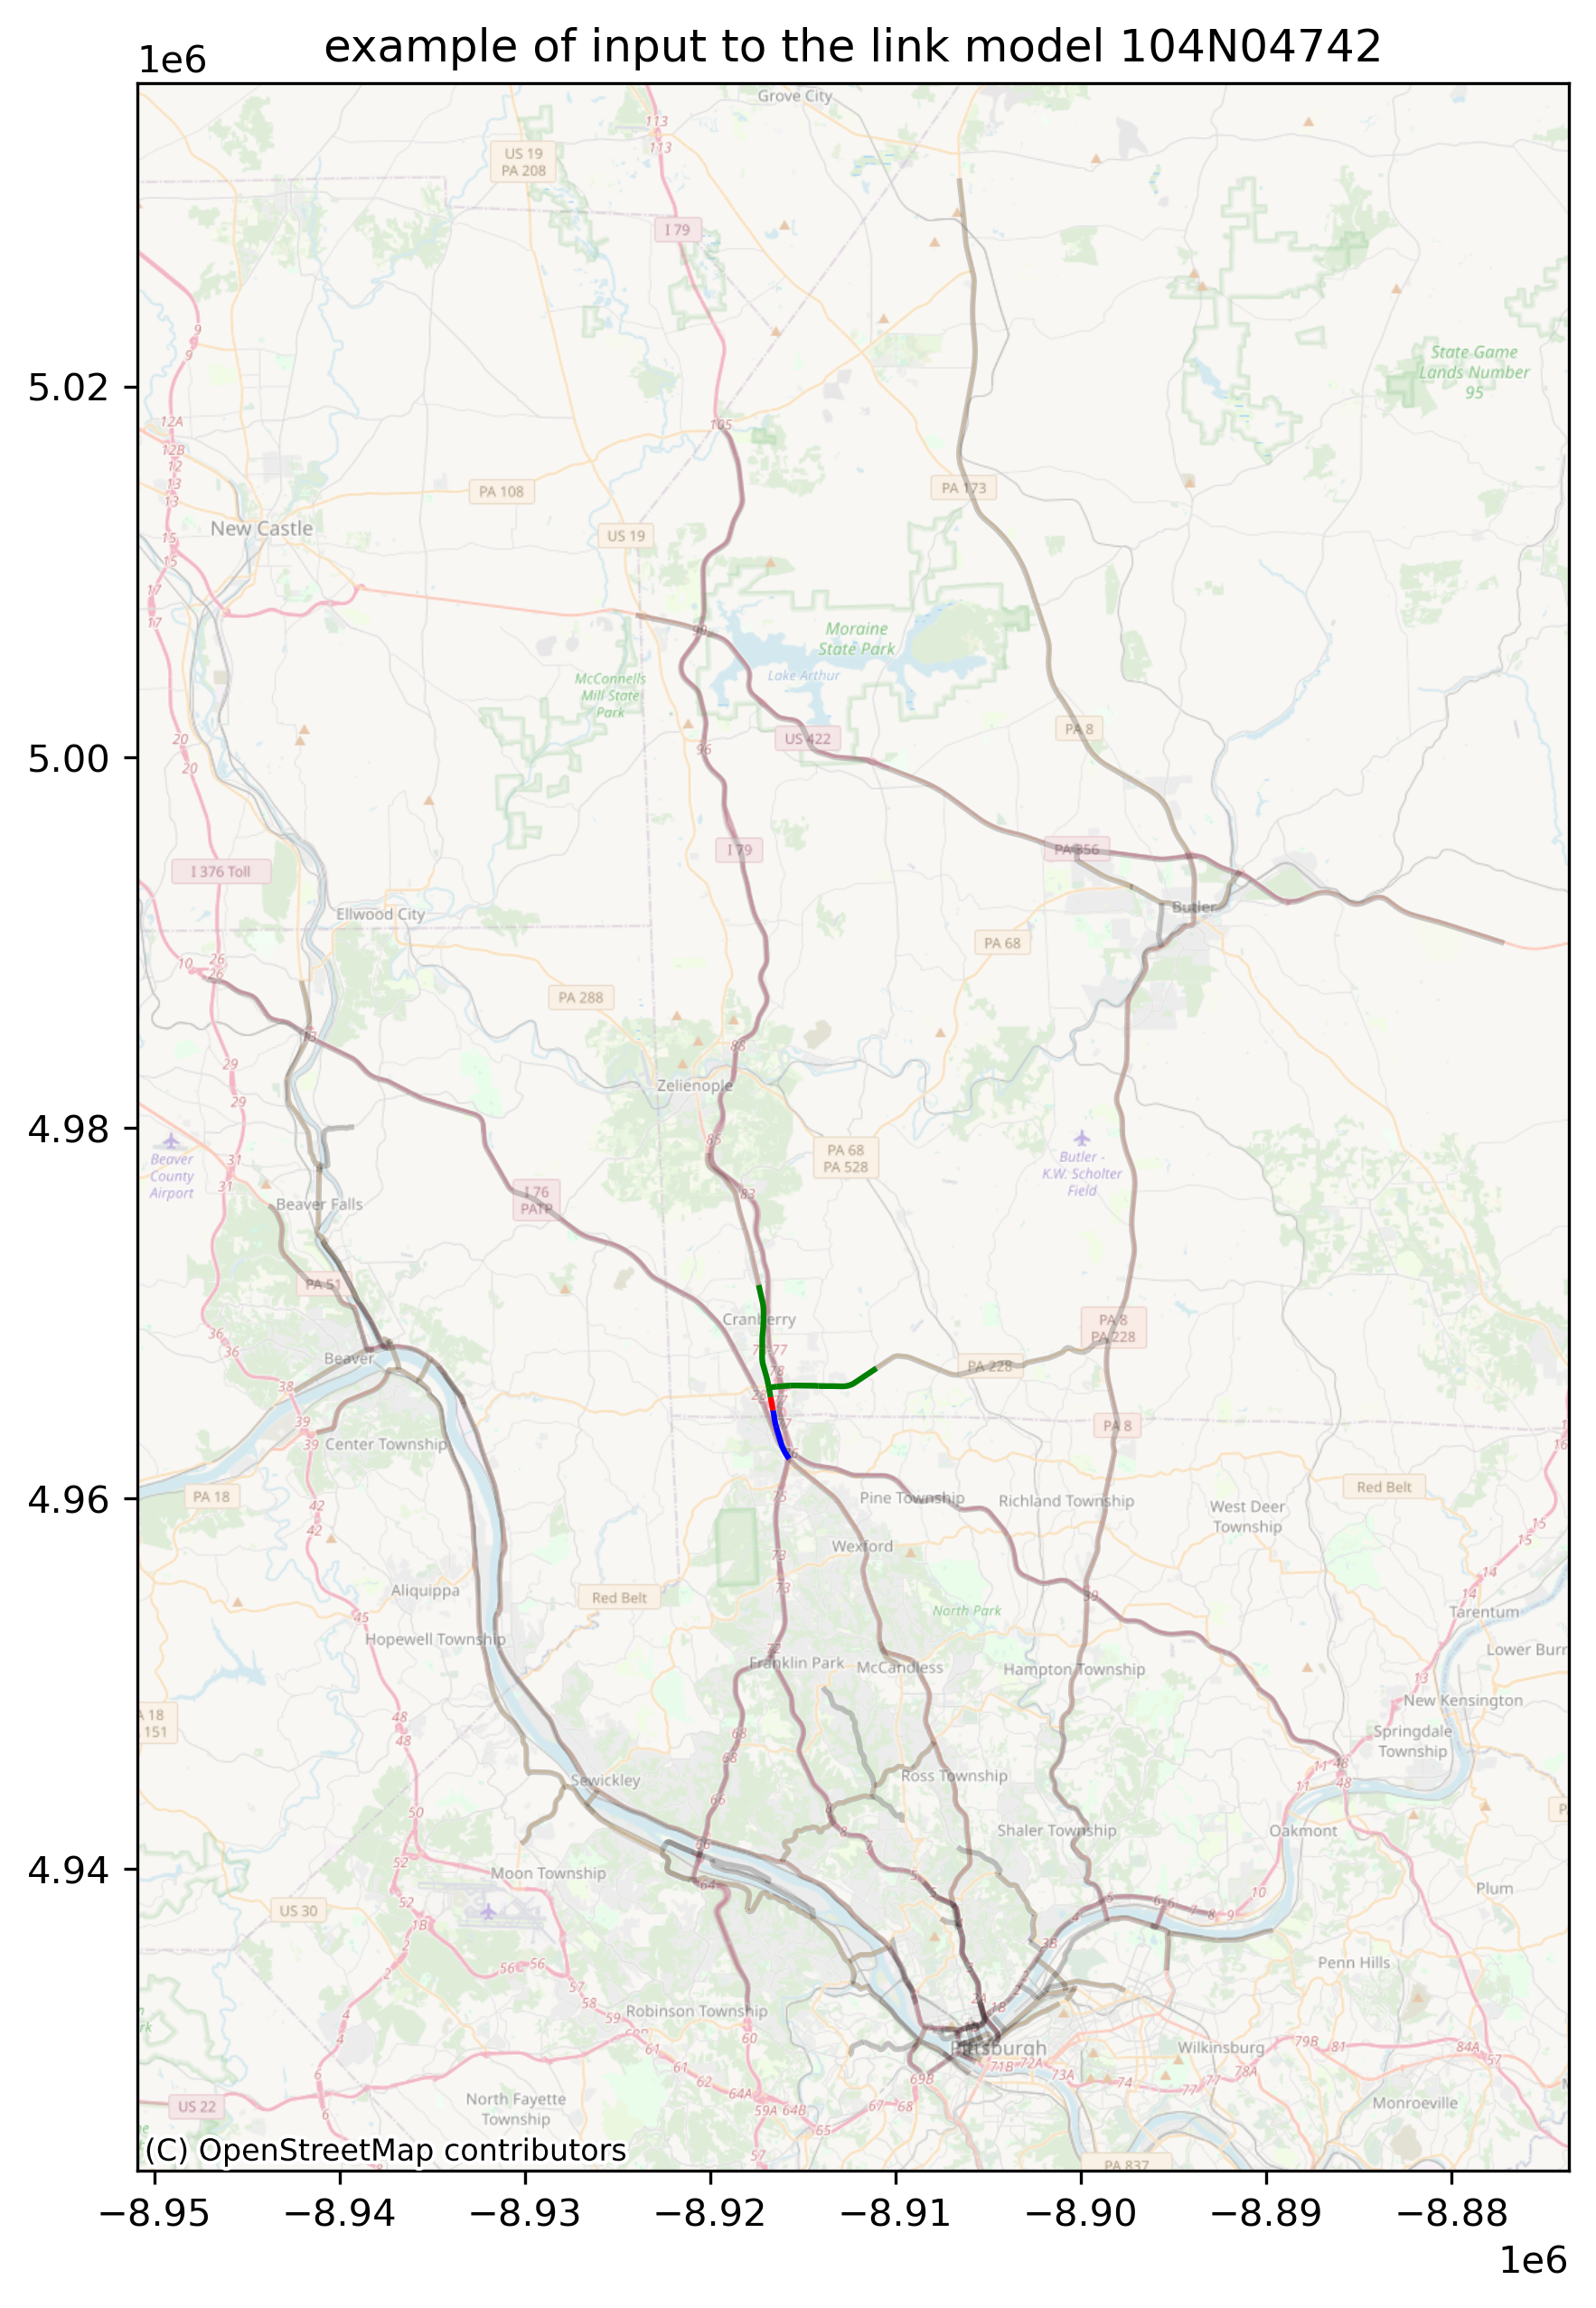

In [31]:
# Visualize TMC segments covered in different sources
gdf_shp_tmc = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_shp_tmc = gdf_shp_tmc.rename(columns={"tmc":"id_tmc"})
fig, ax = plt.subplots(1,figsize=(10,10), dpi=300)
gdf_shp_tmc = gdf_shp_tmc.to_crs(epsg=3857)

gdf_shp_tmc.plot(ax=ax, color="black", alpha = 0.1)
current_link = '104N04742'
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin([current_link])].plot(ax=ax, color="red")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(upstream_k_mile_dict[current_link])].plot(ax=ax, color="green")
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(downstream_k_mile_dict[current_link])].plot(ax=ax, color="blue")
ax.set_title(f"example of input to the link model {current_link}")
gdf_shp_tmc.crs = "EPSG:4326"

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha = 0.5)
# fig.savefig('down_upstream.png', dpi=300, bbox_inches='tight')

## Part 4. Save Dict

In [32]:
for upstream_range_mile in [0.0, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
    upstream_k_mile_dict = build_up_k_mile_upstream_dict(upstream_range_mile)
    upstream_range_mile= float("{:.1f}".format(upstream_range_mile))
    pickle.dump(upstream_k_mile_dict,  open(f"{model_path}/data/{country_name}/processed_data/upstream_rage_dict/{country_name}_upstream_{round(upstream_range_mile,1)}_mile.pkl", "wb"))

100%|██████████| 1080/1080 [00:03<00:00, 351.43it/s]


In [33]:
for downstream_range_mile in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
    downstream_k_mile_dict = build_up_k_mile_downstream_dict(downstream_range_mile)
    downstream_range_mile= float("{:.1f}".format(downstream_range_mile))
    pickle.dump(downstream_k_mile_dict, open(f"{model_path}/data/{country_name}/processed_data/downstream_rage_dict/{country_name}_downstream_{downstream_range_mile}_mile.pkl", "wb"))

100%|██████████| 1047/1047 [00:02<00:00, 408.82it/s]


In [23]:
float("{:.1f}".format(downstream_range_mile))

2.5